# Proyecto Final - Aprendizaje Reforzado - IIC3675
**Autor:** _Lucas Mattias Alvites Galarza_

El objetivo de este proyecto es ver como un agente entrenado en un ambiente dinámico que combina observaciones POMDP y estados MDP puede generalizar mejor a otros ambientes. Este nos ayudará a corroborar la hipótesis sobre que un agente entrenado en un POMDP generalizar mejor que un agente entrenado en un MDP. (Método SWITCH)

## Librerías

In [1]:
%pip install minigrid
%pip install stable-baselines3
%pip install sb3-contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.8 MB/s eta 0:00:00


In [2]:
import random
import time

import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

from minigrid.wrappers import ImgObsWrapper, RGBImgObsWrapper, ReseedWrapper, NoDeath, RGBImgPartialObsWrapper
from minigrid.envs import EmptyEnv

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecMonitor

from sb3_contrib import RecurrentPPO

from gymnasium import Wrapper

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Funciones para gráficos

In [3]:
def show_graph(x: np.ndarray, y: np.ndarray, cuts: np.ndarray = None,
               name: str = None, interval: int = 1, type_g: str = "L",
               title: str = "Rendimiento del agente") -> None:
    """
    Muestra un gráfico promediando cada 'interval' episodios. También dibuja
    líneas verticales en los cortes entre ambientes.

    Args:
        x: Episodios
        y: Valores (rewards o lengths)
        name: Nombre para la leyenda
        cuts: Posición en x donde mostrar la línea vertical
        interval: Intervalo de episodios para agrupar (default: 1)
    """
    x_grouped = []
    y_grouped = []

    if interval <= 1:
        # Usar valores originales
        x_grouped = x
        y_grouped = y
    else:
        # Agrupar de a interval episodios
        for start_idx in range(0, len(y), interval):
            end_idx = min(start_idx + interval, len(y))

            # Episodio representativo
            x_grouped.append(end_idx)

            # Promedio del intervalo
            y_grouped.append(np.mean(y[start_idx:end_idx]))

    x_grouped = np.array(x_grouped)
    y_grouped = np.array(y_grouped)

    plt.figure(figsize=(12, 6))
    plt.plot(x_grouped, y_grouped, label=name)

    if cuts is not None:
        acc = 0
        for c in cuts[:-1]:
            acc += c
            plt.axvline(acc, linestyle='--', linewidth = 1, color = "green", alpha = 0.7)

    if type_g == "L":
        y_label = "Número de pasos"
    elif type_g == "R":
        y_label = "Recompensa"
    else:
        y_label = "Valor"

    plt.xlabel("Episodios")
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, alpha=0.3)

    if name is not None:
        plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
def read_monitor_file(filename: str, type_g: str = "L") -> np.ndarray:
    """
    Lee un archivo .monitor.csv y retorna los largos de episodio.

    Args:
        filename: Ruta del archivo sin extensión .monitor.csv
        max_episodes: Número máximo de episodios a leer

    Returns:
        Array con los largos de episodios
    """
    try:
        df = pd.read_csv(f"{filename}.monitor.csv", skiprows = 1)

        if type_g == "L":
            arr = df['l'].values
        elif type_g == "R":
            arr = df['r'].values
        else: raise ValueError("Only L or R types for graph")

        return arr

    except Exception as e:
        print(f"Error leyendo {filename}: {e}")
        return None

In [5]:
def get_run(base_filename: str, num_files: int, type_g: str = "L",
            max_episodes: int = 1000) -> tuple[np.ndarray, np.ndarray]:
    """
    Lee múltiples archivos y retorna un arreglo concatenado y los cortes.

    Args:
        base_filename: Nombre base de los archivos (ej: "dqn/dqn_results")
        num_files: Número de archivos a leer

    Returns:
        joined: np.ndarray con todos los valores concatenados
        cuts: array con longitudes individuales (puntos de corte)
    """
    all_values = []
    cuts = []

    for i in range(num_files):
        filename = f"{base_filename}_{i}"
        values = read_monitor_file(filename, type_g)

        if values is not None:
            all_values.append(values)
            cuts.append(len(values))
            print(f"Corrida {i}: {len(values)} episodios")
        else:
            print(f"Advertencia: No se pudo leer corrida {i}")

    if not all_values:
        raise ValueError("No se pudo leer ningún archivo")

    # Concatenar en un vector único
    joined = np.concatenate(all_values)

    return joined[:max_episodes], cuts

## Wrappers

In [ ]:
class BadSensorsObsWrapper(gym.ObservationWrapper):
    """
    Este wrappers sirve para mofificar las observaciones de un entorno.
    Estas modificaciones alternan entre:
    - Observación completa del entorno (MDP).
    - Observación parcial del entorno (POMDP).
    """


    def __init__(self, env: gym.Env, seed: int, min_steps: int = 100,
                 max_steps: int = 500, hidden_tiles_min: int = 10,
                 hidden_tiles_max: int = 100, fail_duration: int = 10):
        #env = NoDeath(env, no_death_types = ("lava",), death_cost = -1.0)
        env = RGBImgPartialObsWrapper(env, tile_size = 8)
        env = ImgObsWrapper(env) # Para obtener solo la imagen como observación
        if seed != None:
          env = ReseedWrapper(env, seeds = [seed])
        super().__init__(env)
        #env.unwrapped.highlight = False
        self.env.unwrapped.tile_size = 8

        self.min_steps = min_steps
        self.max_steps = max_steps

        self.hidden_tiles_min = hidden_tiles_min
        self.hidden_tiles_max = hidden_tiles_max

        self.fail_duration = fail_duration # Duracion del fallo

        self.steps_failing = 0 # Pasos que llevan fallando
        self.steps = 0 # Pasos que llevan OK
        self.threshold = random.randint(self.min_steps, self.max_steps) # Cada cuantos pasos fallan los sensores

        self.sensors_status_ok = random.choice([True, False])


    def observation(self, obs: np.ndarray) -> np.ndarray:
        img = obs.copy()

        if not self.sensors_status_ok:
            img = self.__apply_partial_observation(img)

        return img


    def __apply_partial_observation(self, img: np.ndarray) -> np.ndarray:
        """
        Pone en negro N tiles aleatorios del grid.
        """
        # Número de tiles a ocultar en cada paso
        N = random.randint(self.hidden_tiles_min, self.hidden_tiles_max)

        tile_pixels = self.env.unwrapped.tile_size
        H, W = self.env.unwrapped.height, self.env.unwrapped.width # Dimensiones del grid

        # Todas las posiciones del grid
        all_tiles = [(x, y) for x in range(W) for y in range(H)]
        # Elegimos aleatoriamente N tiles
        N = min(N, len(all_tiles))
        tiles_to_hide = random.sample(all_tiles, N)

        # Copiamos la imagen para modificarla
        out = img.copy()

        # Ocultamos cada tile
        for (tx, ty) in tiles_to_hide:
            py = tx * tile_pixels
            px = ty * tile_pixels

            out[py : py + tile_pixels, px : px + tile_pixels] = 0

        return out


    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)

        # Si los sensores estan bien
        if self.sensors_status_ok:
            if self.steps >= self.threshold:
                self.__switch_mode()
            self.steps += 1 # Sensores OK
        else: # Si estan mal
            if self.steps_failing >= self.fail_duration:
                self.__switch_mode()
            self.steps_failing += 1 # Sensores fallando

        return self.observation(obs), reward, done, truncated, info


    def __switch_mode(self) -> None:
        # Reinicio de contadores
        self.steps = 0
        self.steps_failing = 0
        # Nueva cantidad de pasos hasta que fallen los sensores al cambiar de Fallando a OK
        if not self.sensors_status_ok:
            self.threshold = random.randint(self.min_steps, self.max_steps)
        # Cambio de modo
        self.sensors_status_ok = not self.sensors_status_ok


    def reset(self, **kwargs):
        self.steps = 0
        self.threshold = random.randint(self.min_steps, self.max_steps)

        obs, info = self.env.reset(**kwargs)

        return self.observation(obs), info


## Enviroments

Para lograr probar la hipótesis, vamos a testear el metodo SWITCH en diferentes "super-ambientes". Tomando en cuenta la regla del 70% para entrenamiento y 30% para test.

In [13]:
NUM_ENVS = 8
TRAIN_ENVS = int(NUM_ENVS * 1)

### Empty Room

In [ ]:
gym.envs.registration.register(
    id = 'MiniGrid-Empty-9x9-v0',
    entry_point = 'minigrid.envs:EmptyEnv',
    kwargs = {'size': 9},
    max_episode_steps = 1000
)

In [ ]:
env_empty9_name = "MiniGrid-Empty-9x9-v0"

def make_empty():
  def _init():
    env = gym.make(env_empty9_name,
                   render_mode = 'rgb_array',
                   max_steps = 1000)
    env = BadSensorsObsWrapper(env = env,
                               seed = None,
                               min_steps = 4, max_steps = 8,
                               hidden_tiles_min = 8, hidden_tiles_max = 32,
                               fail_duration = 4)
    return env
  return _init

rppo_train_empty9 = DummyVecEnv([make_empty() for _ in range(TRAIN_ENVS)])
rppo_train_empty9 = VecMonitor(rppo_train_empty9,
                               filename = f"rppo/{env_empty9_name}/train/results_0")

ppo_train_empty9 = DummyVecEnv([make_empty() for _ in range(TRAIN_ENVS)])
ppo_train_empty9 = VecMonitor(ppo_train_empty9,
                              filename = f"ppo/{env_empty9_name}/train/results_0")

### Simple Crossing N1

In [ ]:
env_simple_crossing_n1_name = "MiniGrid-SimpleCrossingS9N1-v0"

# TRAIN
def make_simple_n1():
  def _init():
    seed = None

    env = gym.make(env_simple_crossing_n1_name,
                   render_mode = 'rgb_array',
                   max_steps = 1000)
    env = BadSensorsObsWrapper(env = env,
                               seed = seed,
                               min_steps = 4, max_steps = 8,
                               hidden_tiles_min = 32, hidden_tiles_max = 64,
                               fail_duration = 8)
    return env
  return _init

# Train
rppo_train_simple_n1_crossing = DummyVecEnv([make_simple_n1() for _ in range(TRAIN_ENVS)])
rppo_train_simple_n1_crossing = VecMonitor(rppo_train_simple_n1_crossing,
                                      filename = f"rppo/{env_simple_crossing_n1_name}/train/results_0")

ppo_train_simple_n1_crossing = DummyVecEnv([make_simple_n1() for _ in range(TRAIN_ENVS)])
ppo_train_simple_n1_crossing = VecMonitor(ppo_train_simple_n1_crossing,
                                      filename = f"ppo/{env_simple_crossing_n1_name}/train/results_0")

### Door Key

In [23]:
env_door_key_name = "MiniGrid-DoorKey-8x8-v0"

# TRAIN
def make_door_key():
  def _init():
    seed = None

    env = gym.make(env_door_key_name,
                   render_mode = 'rgb_array',
                   max_steps = 1000)
    env = BadSensorsObsWrapper(env = env,
                               seed = seed,
                               min_steps = 4, max_steps = 8,
                               hidden_tiles_min = 8, hidden_tiles_max = 16,
                               fail_duration = 8)
    return env
  return _init

# Train
rppo_train_door_key = DummyVecEnv([make_door_key() for _ in range(TRAIN_ENVS)])
rppo_train_door_key = VecMonitor(rppo_train_door_key,
                                 filename = f"rppo/{env_door_key_name}/train/results_0")

ppo_train_door_key = DummyVecEnv([make_door_key() for _ in range(TRAIN_ENVS)])
ppo_train_door_key = VecMonitor(ppo_train_door_key,
                                filename = f"ppo/{env_door_key_name}/train/results_0")

### Memory

In [14]:
env_mem_name = "MiniGrid-MemoryS17Random-v0"

# TRAIN
def make_mem():
  def _init():
    seed = None

    env = gym.make(env_mem_name,
                   render_mode = 'rgb_array',
                   max_steps = 1000)
    env = BadSensorsObsWrapper(env = env,
                               seed = seed,
                               min_steps = 4, max_steps = 8,
                               hidden_tiles_min = 8, hidden_tiles_max = 32,
                               fail_duration = 8)
    return env
  return _init

# Train
rppo_train_mem = DummyVecEnv([make_mem() for _ in range(TRAIN_ENVS)])
rppo_train_mem = VecMonitor(rppo_train_mem,
                                 filename = f"rppo/{env_mem_name}/train/results_0")

ppo_train_mem = DummyVecEnv([make_mem() for _ in range(TRAIN_ENVS)])
ppo_train_mem = VecMonitor(ppo_train_mem,
                                filename = f"ppo/{env_mem_name}/train/results_0")

# Recurrent PPO

Ahora vamos a modificar los parámetros del agente usando una CNN

## Entrenamiento

### Agente en Empty 9x9

In [ ]:
model_empty9 = RecurrentPPO("CnnLstmPolicy", env = rppo_train_empty9, verbose = 1,
                            learning_rate = 1e-4,
                            n_steps = 256,
                            batch_size = 2048,
                            n_epochs = 4,
                            ent_coef = 0.01,
                            gamma = 0.99,
                            clip_range = 0.15,
                            policy_kwargs = dict(shared_lstm = False,
                                                 enable_critic_lstm = True,
                                                 lstm_hidden_size = 256,
                                                 n_lstm_layers = 1,
                                                 net_arch = [128, 128]))

Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
model_empty9.learn(total_timesteps = int(1e5),
                   log_interval = 4,
                   progress_bar = True)
# Save Temp
model_empty9.save(f"rppo_agent/{env_empty9_name}/train_base")

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.1         |
|    ep_rew_mean          | 0.944        |
| time/                   |              |
|    fps                  | 498          |
|    iterations           | 4            |
|    time_elapsed         | 16           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0003263177 |
|    clip_fraction        | 0.00183      |
|    clip_range           | 0.15         |
|    entropy_loss         | -0.871       |
|    explained_variance   | 0.4          |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00341     |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 0.0174       |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

#### Gráfica

Corrida 0: 7086 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


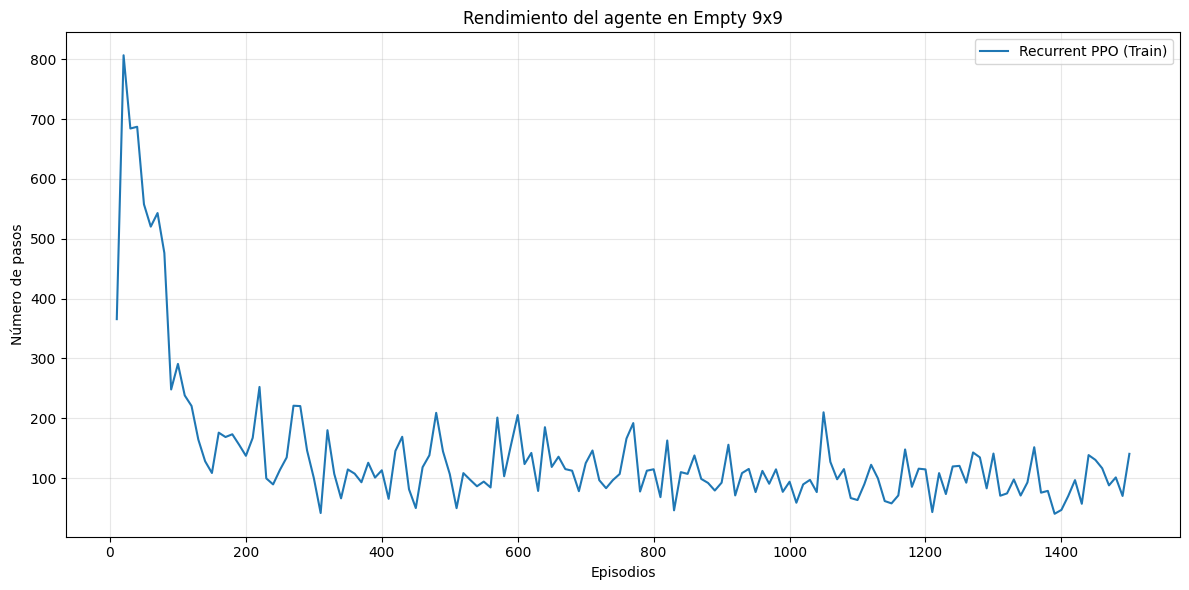

In [ ]:
avg_ep_len_e, cuts = get_run(f"rppo/{env_empty9_name}/train/results", 1, max_episodes = 1500)
episodes = np.arange(1, len(avg_ep_len_e) + 1)
show_graph(episodes, avg_ep_len_e, cuts, name = "Recurrent PPO (Train)", interval = 10, title = "Rendimiento del agente en Empty 9x9")

Corrida 0: 11010 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


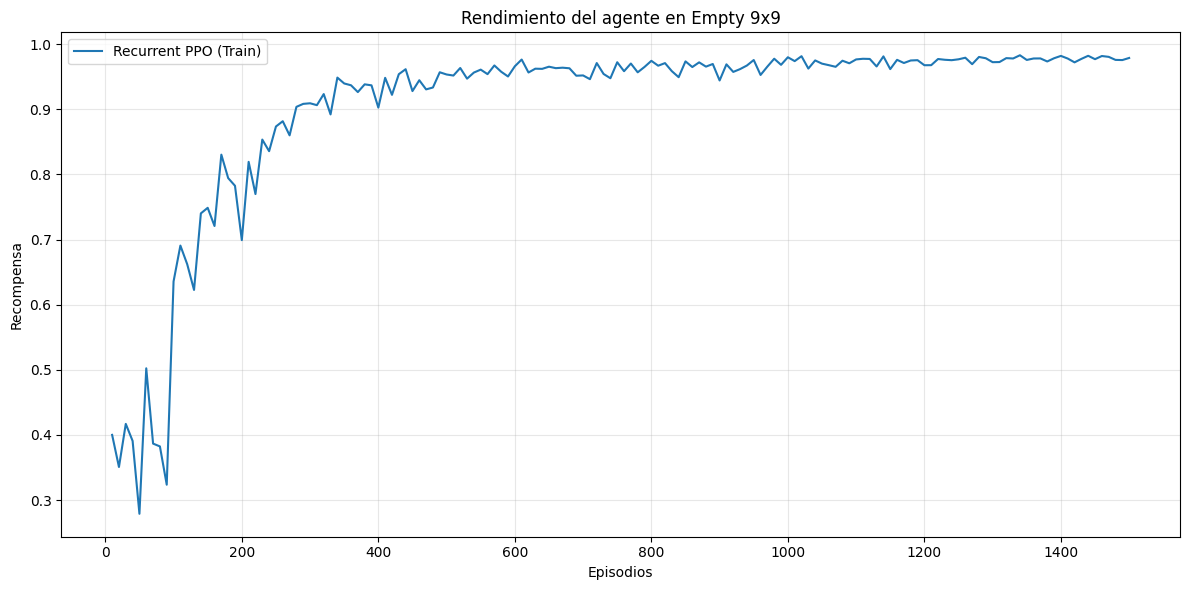

In [ ]:
avg_ep_rew_e, cuts = get_run(f"rppo/{env_empty9_name}/train/results", 1, type_g = "R", max_episodes = 1500)
episodes = np.arange(1, len(avg_ep_rew_e) + 1)
show_graph(episodes, avg_ep_rew_e, cuts, name = "Recurrent PPO (Train)", interval = 10, title = "Rendimiento del agente en Empty 9x9", type_g = "R")

### Agente en Simple Crossing N1

In [ ]:
model_simple_n1_crossing = RecurrentPPO("CnnLstmPolicy", env = rppo_train_simple_n1_crossing, verbose = 1,
                                        learning_rate = 1e-4,
                                        n_steps = 256,
                                        batch_size = 2048,
                                        n_epochs = 4,
                                        ent_coef = 0.01,
                                        gamma = 0.99,
                                        clip_range = 0.15,
                                        policy_kwargs = dict(shared_lstm = False,
                                                             enable_critic_lstm = True,
                                                             lstm_hidden_size = 256,
                                                             n_lstm_layers = 1,
                                                             net_arch = [128, 128]))

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
model_simple_n1_crossing.learn(total_timesteps = int(1e6), # 1e6
                               log_interval = 8,
                               progress_bar = True)
# Save Temp
model_simple_n1_crossing.save(f"rppo_agent/{model_simple_n1_crossing}/train_result_no_base")

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 903          |
|    ep_rew_mean          | 0.118        |
| time/                   |              |
|    fps                  | 357          |
|    iterations           | 8            |
|    time_elapsed         | 45           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 5.684851e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.15         |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.312       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0186      |
|    n_updates            | 28           |
|    policy_gradient_loss | -1.1e-05     |
|    value_loss           | 0.00195      |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

KeyboardInterrupt: 

#### Gráfica

In [ ]:
avg_ep_len_sc1, cuts = get_run(f"rppo/{env_simple_crossing_n1_name}/train/results", 1, max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_sc1) + 1)
show_graph(episodes, avg_ep_len_sc1, cuts, name = "Recurrent PPO (Train)", interval = 10, title = "Rendimiento del agente en Simple Crossing")

In [ ]:
avg_ep_rew_sc1, cuts = get_run(f"rppo/{env_simple_crossing_n1_name}/train/results", 1, type_g = "R", max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_rew_sc1) + 1)
show_graph(episodes, avg_ep_rew_sc1, cuts, name = "Recurrent PPO (Train)", interval = 10, title = "Rendimiento del agente en Simple Crossing", type_g = "R")

### Agente en Door Key

In [42]:
model_dk_rppo = RecurrentPPO("CnnLstmPolicy", env = rppo_train_door_key, verbose = 1,
                             learning_rate = 1e-4,
                             n_steps = 256,
                             batch_size = 2048,
                             n_epochs = 4,
                             ent_coef = 0.01,
                             gamma = 0.99,
                             clip_range = 0.18,
                             policy_kwargs = dict(shared_lstm = False,
                                                  enable_critic_lstm = True,
                                                  lstm_hidden_size = 512,
                                                  n_lstm_layers = 1,
                                                  net_arch = [128, 128]))

Using cuda device
Wrapping the env in a VecTransposeImage.


In [44]:
model_dk_rppo.learn(total_timesteps = int(2e5), # 8e5
                               log_interval = 8,
                               progress_bar = True)
# Save Temp
model_dk_rppo.save(f"rppo_agent/{env_door_key_name}/train_result_no_base")

Output()

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 826          |
|    ep_rew_mean          | 0.194        |
| time/                   |              |
|    fps                  | 529          |
|    iterations           | 8            |
|    time_elapsed         | 30           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0001922519 |
|    clip_fraction        | 0            |
|    clip_range           | 0.18         |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.102        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0178      |
|    n_updates            | 1200         |
|    policy_gradient_loss | -0.000231    |
|    value_loss           | 0.000533     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

KeyboardInterrupt: 

Corrida 0: 816 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


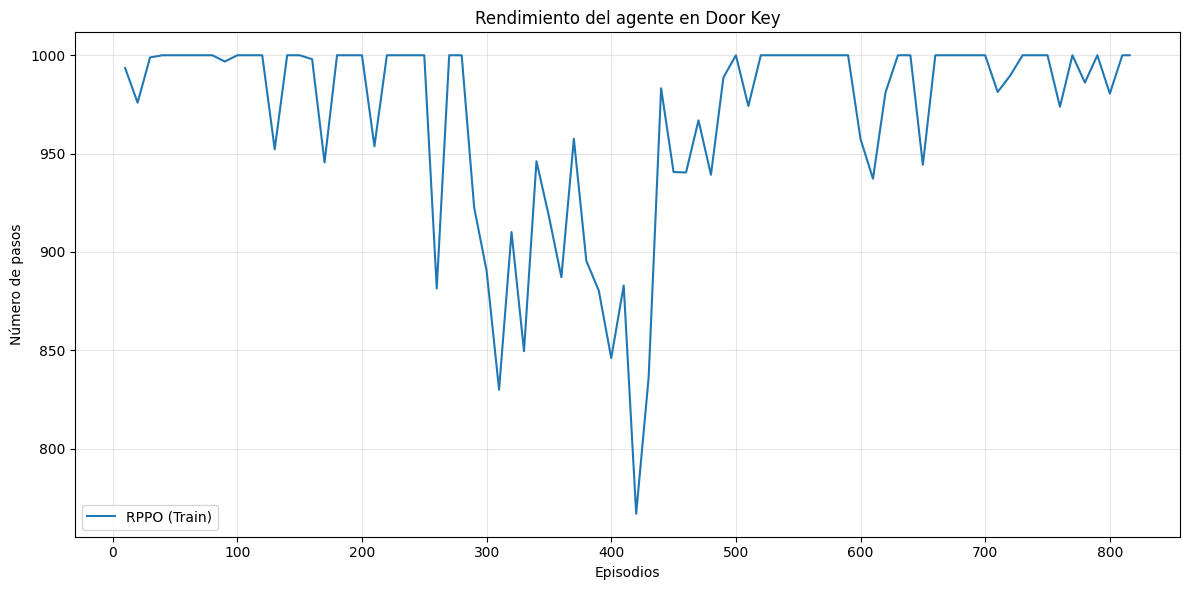

In [40]:
avg_ep_len_ppo_sc1, cuts = get_run(f"rppo/{env_door_key_name}/train/results", 1, max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "RPPO (Train)", interval = 10, title = "Rendimiento del agente en Door Key")

In [ ]:
avg_ep_len_ppo_sc1, cuts = get_run(f"rppo/{env_door_key_name}/train/results", 1, max_episodes = 5000, type_g = "R")
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "RPPO (Train)", interval = 20, title = "Rendimiento del agente en Door Key", type_g = "R")

### Agente en Memory

In [16]:
model_mem_rppo = RecurrentPPO("CnnLstmPolicy", env = rppo_train_mem, verbose = 1,
                             learning_rate = 1e-4,
                             n_steps = 256,
                             batch_size = 2048,
                             n_epochs = 4,
                             ent_coef = 0.01,
                             gamma = 0.99,
                             clip_range = 0.18,
                             policy_kwargs = dict(shared_lstm = False,
                                                  enable_critic_lstm = True,
                                                  lstm_hidden_size = 256,
                                                  n_lstm_layers = 1,
                                                  net_arch = [128, 128]))

Using cuda device
Wrapping the env in a VecTransposeImage.


In [17]:
model_mem_rppo.learn(total_timesteps = int(2e5), # 2e5
                               log_interval = 8,
                               progress_bar = True)
# Save Temp
model_mem_rppo.save(f"rppo_agent/{env_mem_name}/train_result_no_base")

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 505          |
|    ep_rew_mean          | 0.229        |
| time/                   |              |
|    fps                  | 386          |
|    iterations           | 8            |
|    time_elapsed         | 42           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 4.680711e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.18         |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.0116       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0175      |
|    n_updates            | 28           |
|    policy_gradient_loss | -4.97e-06    |
|    value_loss           | 0.00407      |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

NameError: name 'env_door_key_name' is not defined

Corrida 0: 3295 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


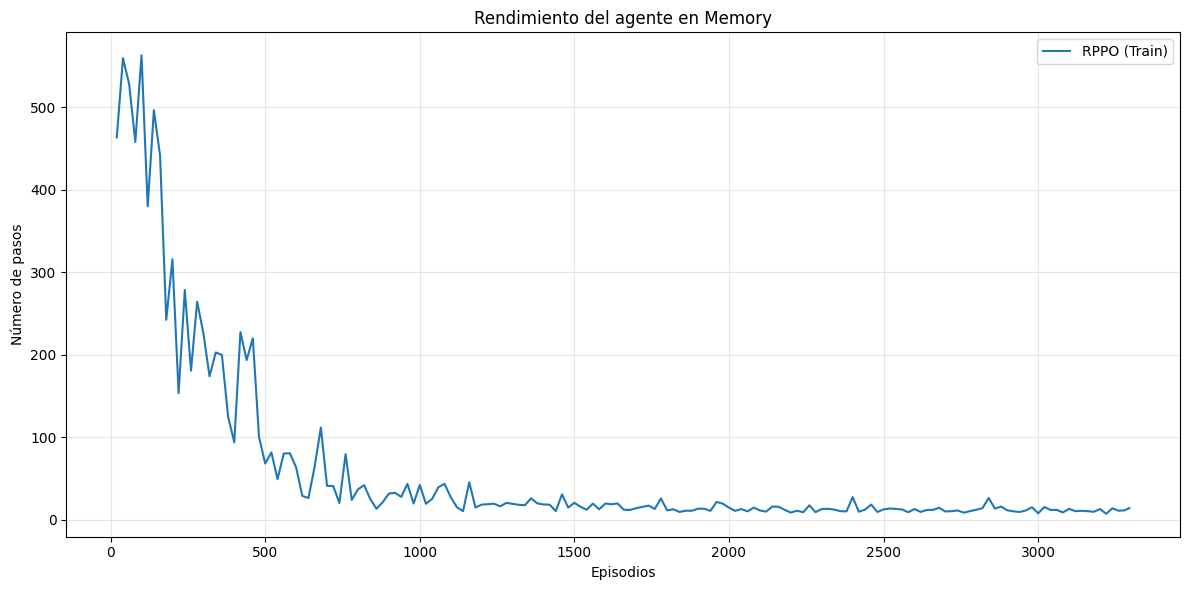

In [18]:
avg_ep_len_ppo_sc1, cuts = get_run(f"rppo/{env_mem_name}/train/results", 1, max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "RPPO (Train)", interval = 20, title = "Rendimiento del agente en Memory")

# PPO

## Entrenamiento

### Agente en Empty 9x9

In [ ]:
ppo_model_empty9 = PPO("CnnPolicy", env = ppo_train_empty9, verbose = 1,
                       learning_rate = 1e-4,
                       n_steps = 256,
                       batch_size = 2048,
                       n_epochs = 4,
                       ent_coef = 0.01,
                       gamma = 0.99,
                       clip_range = 0.15,
                       policy_kwargs = dict(net_arch = [128, 128])
                       )

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
ppo_model_empty9.learn(total_timesteps = int(1e5),
                       log_interval = 8,
                       progress_bar = True)
ppo_model_empty9.save(f"ppo_agent/{env_empty9_name}/train_base")

Output()

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 55.4          |
|    ep_rew_mean          | 0.95          |
| time/                   |               |
|    fps                  | 864           |
|    iterations           | 8             |
|    time_elapsed         | 18            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 0.00017945073 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -0.897        |
|    explained_variance   | 0.38          |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00569      |
|    n_updates            | 420           |
|    policy_gradient_loss | -0.00138      |
|    value_loss           | 0.0125        |
-------------------------------------------
-----------------------------------------
| rollout/                |       

#### Gráfica

Corrida 0: 6120 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


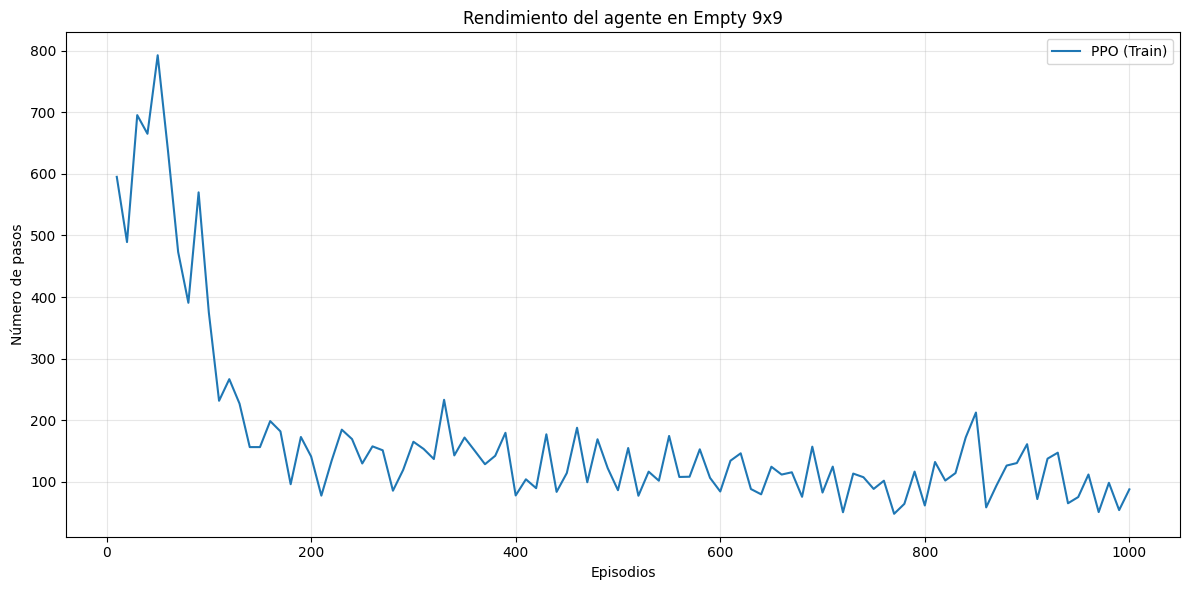

In [ ]:
avg_ep_len_e, cuts = get_run(f"ppo/{env_empty9_name}/train/results", 1, max_episodes = 1000)
episodes = np.arange(1, len(avg_ep_len_e) + 1)
show_graph(episodes, avg_ep_len_e, cuts, name = "PPO (Train)", interval = 10, title = "Rendimiento del agente en Empty 9x9")

Corrida 0: 7335 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


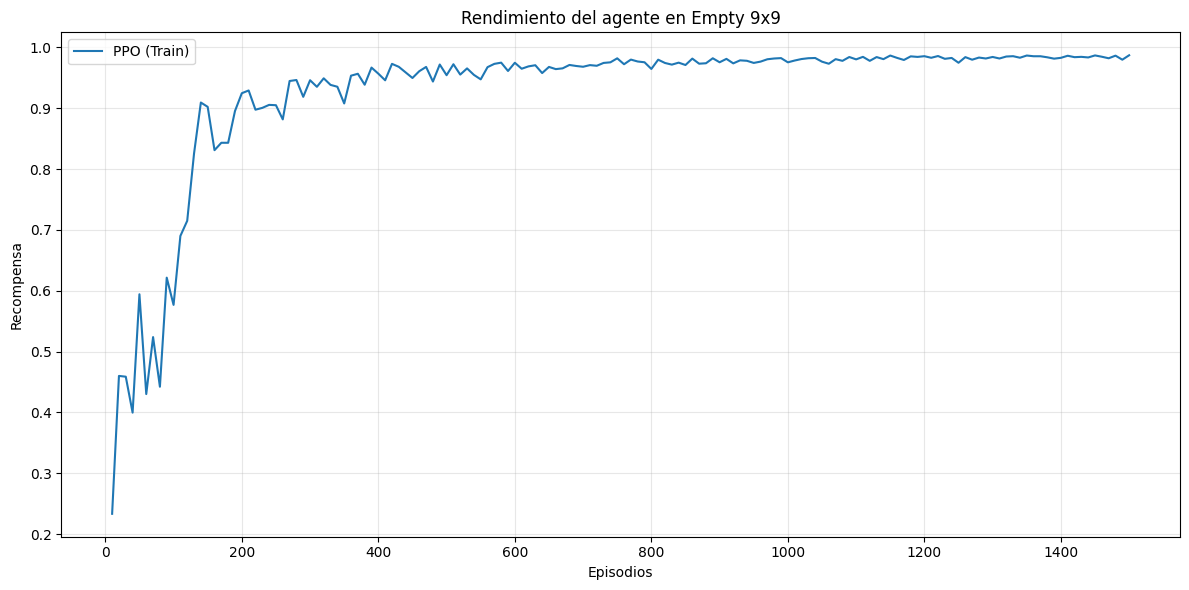

In [ ]:
avg_ep_len_e, cuts = get_run(f"ppo/{env_empty9_name}/train/results", 1, type_g = "R", max_episodes = 1500)
episodes = np.arange(1, len(avg_ep_len_e) + 1)
show_graph(episodes, avg_ep_len_e, cuts, name = "PPO (Train)", interval = 10, title = "Rendimiento del agente en Empty 9x9", type_g = "R")

### Agente en Simple Crossing

In [ ]:
model_ppo_sc_n1 = PPO("CnnPolicy", env = ppo_train_simple_n1_crossing, verbose = 1,
                      learning_rate = 1e-4,
                      n_steps = 256,
                      batch_size = 2048,
                      n_epochs = 4,
                      ent_coef = 0.01,
                      gamma = 0.99,
                      clip_range = 0.15,
                      policy_kwargs = dict(net_arch = [128, 128])
                      )

NameError: name 'ppo_train_simple_n1_crossing' is not defined

In [ ]:
model_ppo_sc_n1.learn(total_timesteps = int(1e6), # 1e6
                               log_interval = 8,
                               progress_bar = True)
# Save Temp
model_ppo_sc_n1.save(f"ppo_agent/{env_simple_crossing_n1_name}/train_result")

Output()

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 916           |
|    ep_rew_mean          | 0.107         |
| time/                   |               |
|    fps                  | 567           |
|    iterations           | 8             |
|    time_elapsed         | 28            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 3.5536068e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.15          |
|    entropy_loss         | -1.95         |
|    explained_variance   | -4.9          |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0178       |
|    n_updates            | 28            |
|    policy_gradient_loss | -1.52e-05     |
|    value_loss           | 0.00373       |
-------------------------------------------
-----------------------------------------
| rollout/                |       

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'ppo_agent/MiniGrid-SimpleCrossingS9N1-v0' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


##### Gráfica

Corrida 0: 4486 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


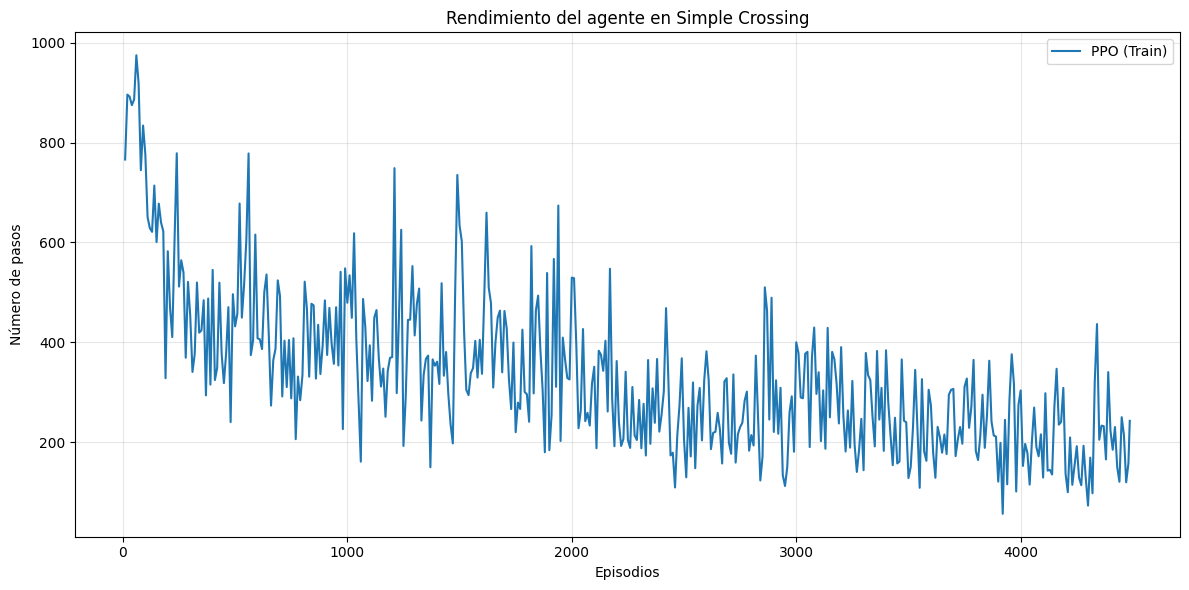

In [ ]:
avg_ep_len_ppo_sc1, cuts = get_run(f"ppo/{env_simple_crossing_n1_name}/train/results", 1, max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "PPO (Train)", interval = 10, title = "Rendimiento del agente en Simple Crossing")

Corrida 0: 4486 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


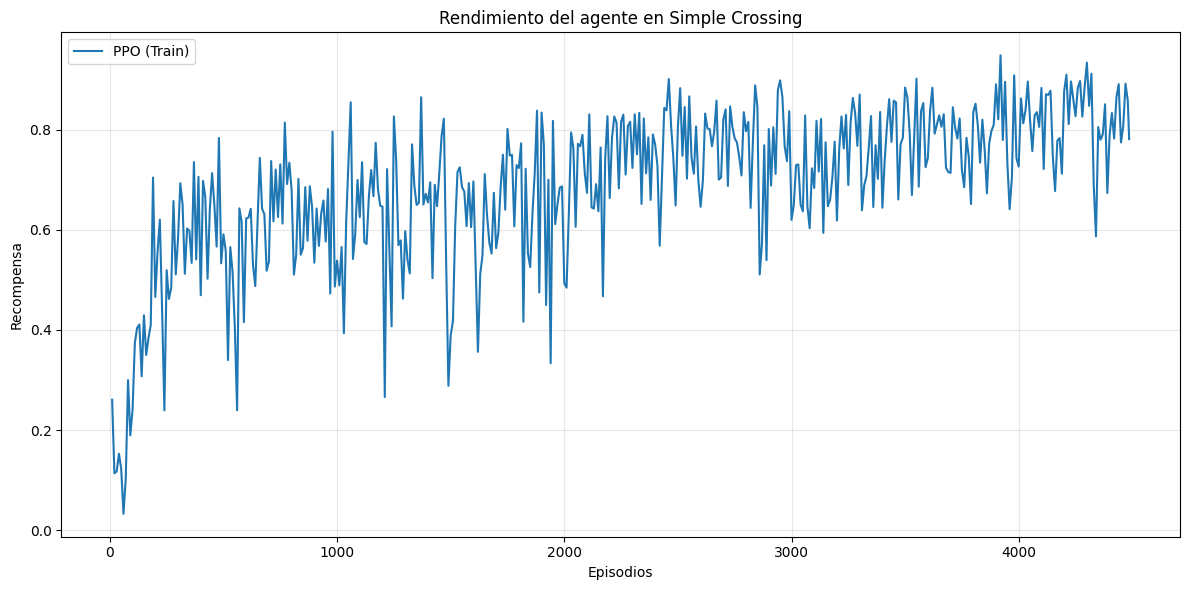

In [ ]:
avg_ep_len_ppo_sc1, cuts = get_run(f"ppo/{env_simple_crossing_n1_name}/train/results", 1, type_g = "R", max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "PPO (Train)", interval = 10, title = "Rendimiento del agente en Simple Crossing", type_g = "R")

### Agente en Door Key

In [24]:
model_ppo_dk = PPO("CnnPolicy", env = ppo_train_door_key, verbose = 1,
                      learning_rate = 1e-4,
                      n_steps = 256,
                      batch_size = 2048,
                      n_epochs = 4,
                      ent_coef = 0.01,
                      gamma = 0.99,
                      clip_range = 0.18,
                      policy_kwargs = dict(net_arch = [128, 128])
                      )

Using cuda device
Wrapping the env in a VecTransposeImage.


In [38]:
model_ppo_dk.learn(total_timesteps = int(2e5), # 8e5
                               log_interval = 8,
                               progress_bar = True)
# Save Temp
model_ppo_dk.save(f"ppo_agent/{env_door_key_name}/train_result_no_base")

Output()

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1e+03         |
|    ep_rew_mean          | 0             |
| time/                   |               |
|    fps                  | 850           |
|    iterations           | 8             |
|    time_elapsed         | 19            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 5.2485208e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.18          |
|    entropy_loss         | -1.94         |
|    explained_variance   | -13.3         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0197       |
|    n_updates            | 1204          |
|    policy_gradient_loss | -0.00018      |
|    value_loss           | 0.000119      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

Corrida 0: 810 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


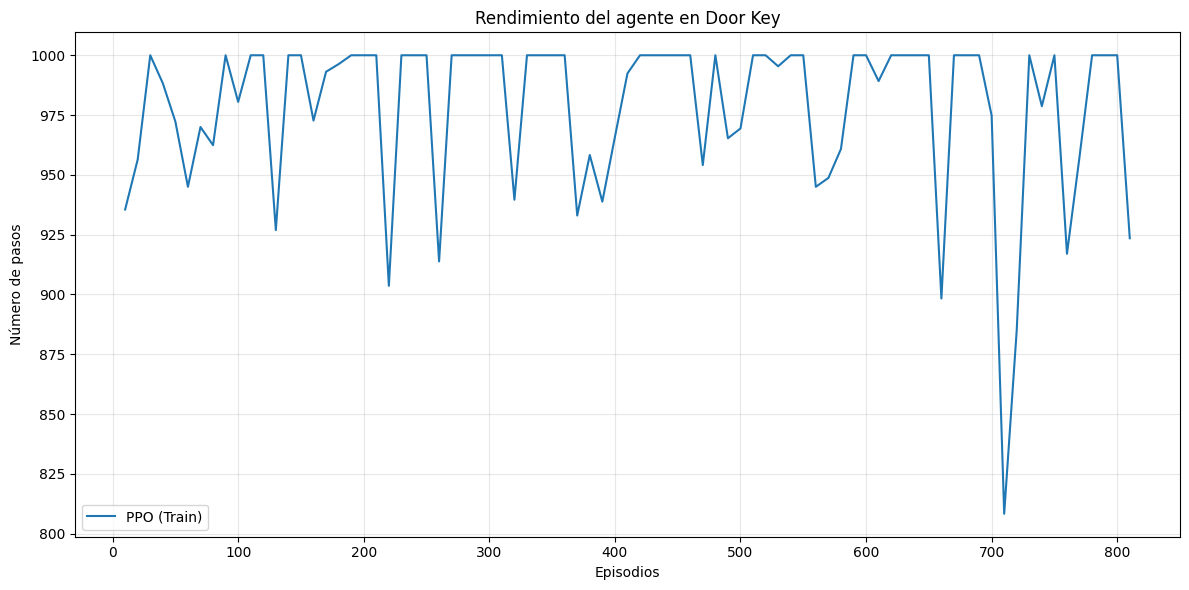

In [39]:
avg_ep_len_ppo_sc1, cuts = get_run(f"ppo/{env_door_key_name}/train/results", 1, max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "PPO (Train)", interval = 10, title = "Rendimiento del agente en Door Key")

Corrida 0: 3698 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


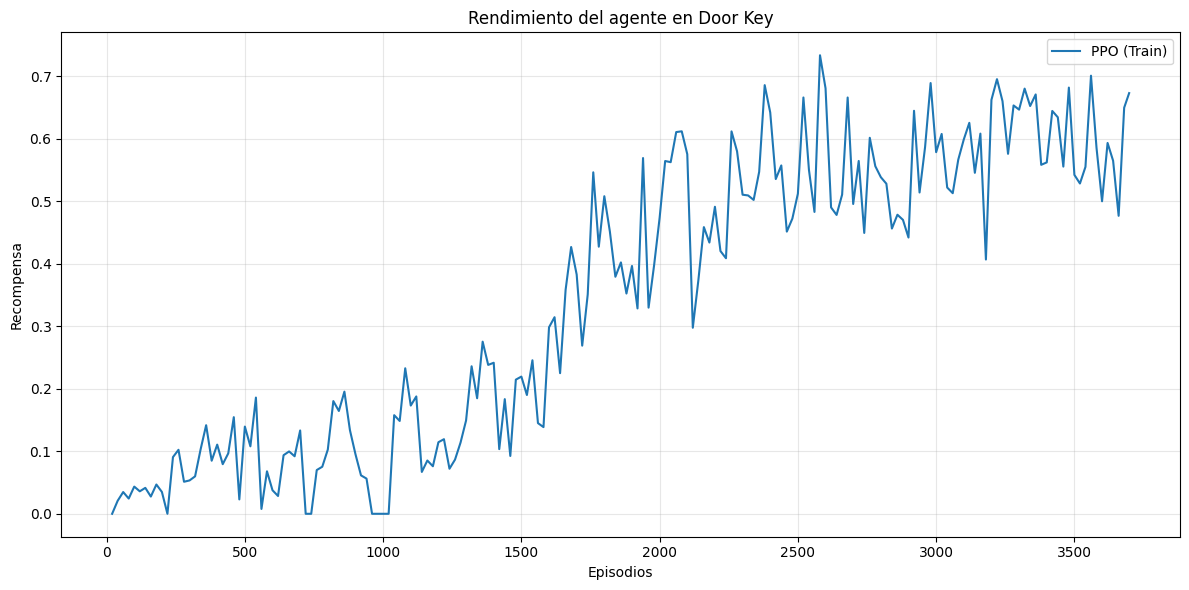

In [ ]:
avg_ep_len_ppo_sc1, cuts = get_run(f"ppo/{env_door_key_name}/train/results", 1, max_episodes = 5000, type_g = "R")
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "PPO (Train)", interval = 20, title = "Rendimiento del agente en Door Key", type_g = "R")

### Agente en Memory

In [19]:
model_ppo_mem = PPO("CnnPolicy", env = ppo_train_mem, verbose = 1,
                      learning_rate = 1e-4,
                      n_steps = 256,
                      batch_size = 2048,
                      n_epochs = 4,
                      ent_coef = 0.01,
                      gamma = 0.99,
                      clip_range = 0.18,
                      policy_kwargs = dict(net_arch = [128, 128])
                      )

Using cuda device
Wrapping the env in a VecTransposeImage.


In [20]:
model_ppo_mem.learn(total_timesteps = int(2e5), # 2e5
                               log_interval = 8,
                               progress_bar = True)
# Save Temp
model_ppo_mem.save(f"ppo_agent/{env_mem_name}/train_result_no_base")

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 541           |
|    ep_rew_mean          | 0.141         |
| time/                   |               |
|    fps                  | 824           |
|    iterations           | 8             |
|    time_elapsed         | 19            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 2.8538227e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.18          |
|    entropy_loss         | -1.94         |
|    explained_variance   | -4.77         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0185       |
|    n_updates            | 28            |
|    policy_gradient_loss | -0.000209     |
|    value_loss           | 0.00292       |
-------------------------------------------
------------------------------------------
| rollout/                |      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'ppo_agent/MiniGrid-MemoryS17Random-v0' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Corrida 0: 2132 episodios


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


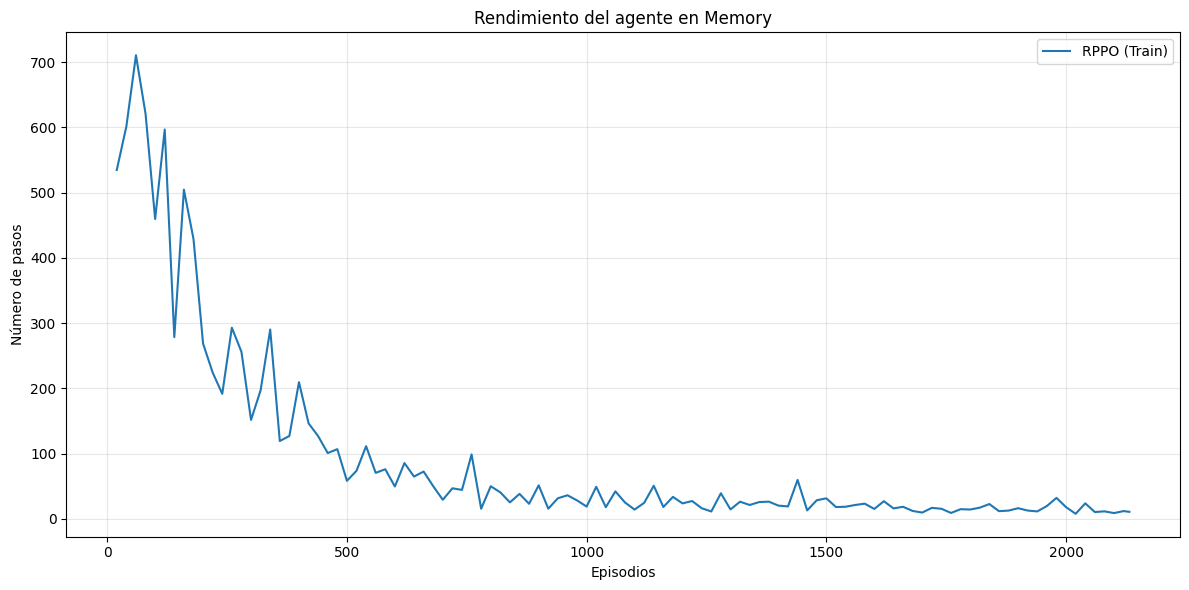

In [21]:
avg_ep_len_ppo_sc1, cuts = get_run(f"ppo/{env_mem_name}/train/results", 1, max_episodes = 5000)
episodes = np.arange(1, len(avg_ep_len_ppo_sc1) + 1)
show_graph(episodes, avg_ep_len_ppo_sc1, cuts, name = "RPPO (Train)", interval = 20, title = "Rendimiento del agente en Memory")

# Save All

In [ ]:
import shutil

In [ ]:
shutil.make_archive("dk-rppo-1-12-v0.2", 'zip', "./rppo/")
shutil.make_archive("dk-ppo-1-12-v0.2", 'zip', "./ppo/")
print("No olvidar descargar el modelo train_6.zip")

No olvidar descargar el modelo train_6.zip
